<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/01_neural_network_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap

# **config**
---

In [158]:
sns.set(style='darkgrid')
title_data = 'Diabetes'
paleta = sns.color_palette("tab10").as_hex()

In [159]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except Exception as e:
        print(e)

  except Exception as e:
    print(e)

def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()



def matrix_confusion(
    y_true:pd.Series,
    y_pred:pd.Series,
    churm:str='True',
    no_churm:str='False',
    title:str='Matriz de confusion',
    x_size:int=6,
    y_size:int=5,
    **kwards)->np.ndarray:
    """confusion matrix"""
    try:
      matrix = metrics.confusion_matrix(y_true, y_pred)
      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(x_size, y_size))
      sns.heatmap(matrix, annot=True, ax=ax, fmt='g', **kwards)
      ax.set_title(title,size=20)
      ax.xaxis.set_ticklabels([no_churm,churm])
      ax.yaxis.set_ticklabels([no_churm,churm])
      ax.tick_params(labelsize = 12)
      fig.show()
      return matrix
    except Exception as e:
      print(e)

# **Objetivos**
---
- Entender y codificar sobre el conjunto de datos en el problema de diagnosticar si un paciente mujer tiene o no diabetes del pueblo pima:
 - curvas de aprendizaje
 - sesgo de predicción
 - matrix confusión
 - Metricas
   - Accuracy
   - Kappa     
   - Precision
   - Recall
   - Specificity
   - F1-score
 - Precision-recall




## **Dicionario de datos**
---
- `Pregnancies` : número de veces de embarazo
- `Glucose` : concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia oral a la glucosa
- `BloodPressure`: presión arterial diastólica (mm Hg)
- `SkinThickness`: grosor del pliegue cutáneo del tríceps (mm)
- `Insulin` : insulina sérica de 2 horas (mu U/ml)
- `BMI` : Índice de masa corporal (peso en kg/(altura en m)^2)
- `DiabetesPedigreeFunction`: función de pedigrí de diabetes
- `Age`: edad
- `Outcome`: está enfermo?

In [160]:
url='https://drive.google.com/file/d/1FGFPdobSr2bMdYJOou-qWV8pJ1iOiW5d/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

In [161]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [162]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [163]:
data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']] =  data[[
    'Pregnancies',
    'Glucose',
    'BloodPressure',
    'SkinThickness',
    'Insulin',
    'Age',
    'Outcome']].astype('int32')



data[[
    'BMI',
    'DiabetesPedigreeFunction']] = data[['BMI',
                                         'DiabetesPedigreeFunction']].astype('float32')

# **Data Split**
---

In [164]:
X = data.iloc[:, :8]
y = data.iloc[:, 8]

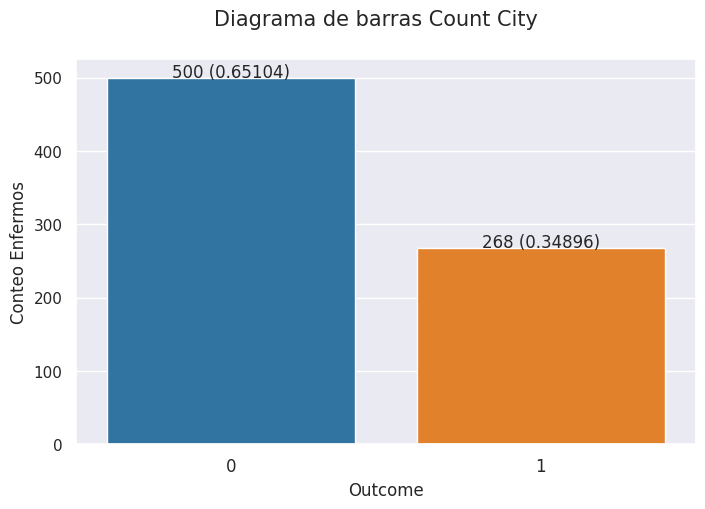

In [165]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='Outcome',
    ejey='Conteo Enfermos',
    title='Count City', p=True)

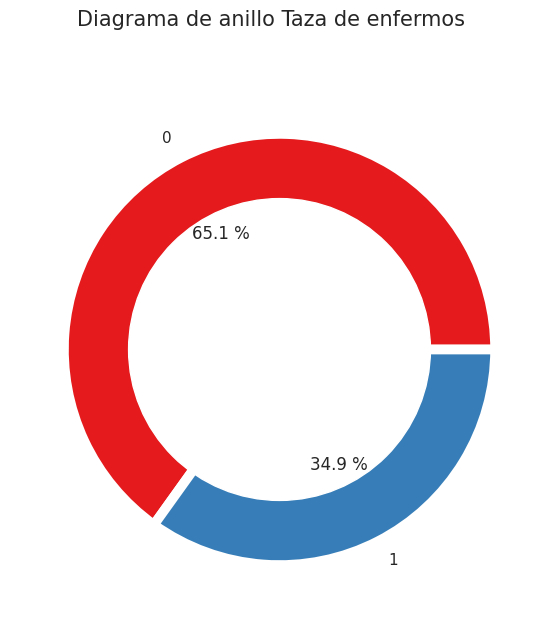

In [166]:
pie_circle(data['Outcome'], title='Taza de enfermos')

Hay un desbalance en el conjunto de datos del 65% para los pacientes sanos, y 35% para los pacientes enfermos.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=12354,
    shuffle=True
)

# **Model**
---

In [168]:
def base_model():
  model = Sequential()
  model.add(Dense(12, input_dim=8, activation='relu',
                  kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation='relu',
                  kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid',
                  kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

In [169]:
model = base_model()

In [170]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=16,
    verbose=0)

In [171]:
500/16

31.25

31 lotes con 16 registros para actualizar la red neuronal.

In [172]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12)                108       
                                                                 
 dense_25 (Dense)            (None, 8)                 104       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

# **Curva de aprendizaje**
---

## **Curvas de aprendizaje de optimización**
---



In [174]:
type(history)

keras.src.callbacks.History

In [182]:
def optimization_learning_curves(
    history:dict,
    metrica:str,
    title:str='',
    X_size:int=8,
    y_size:int=4,
    font_size:int=15,
    X_label:str='Epoch',
    y_label:str='Loss'
)->None:
  """ Grafica curvas de aprendizaje """
  fig, ax = plt.subplots(figsize=(X_size, y_size))
  fig.suptitle(title, fontsize=font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(X_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper right', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

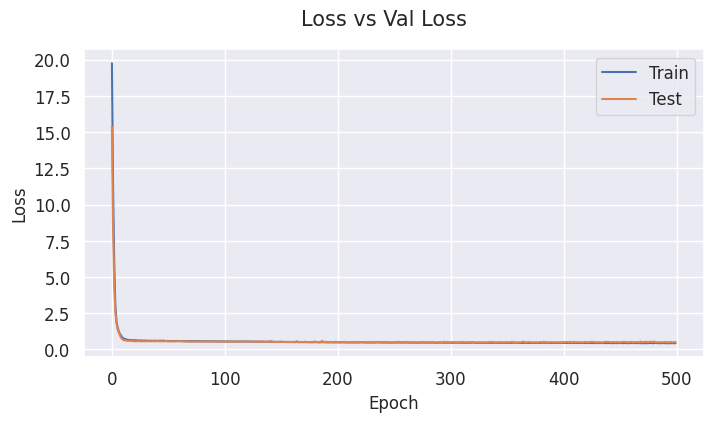

In [183]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

- La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 300 epocas, con una `brecha de generailización` inperceptible.
- Los datos de entrenamiento y validación son representativos para este conjunto de datos.

# **Predictions**
---

In [180]:
y_pred = (model.predict(X_test) > 0.5).astype('int32')

5/5 [==============================] - 0s 4ms/step


In [181]:
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int32)

In [ ]:
# Sesgo predictivo
#sesgo predicción = promedio de predicciones - promedio de etiquetas (observaciones) en el conjunto de datos
def sesgo_prediction(y_pred:pd.Series,
                     y_valid:pd.Series,
                     target:int)->tuple:
  """ Calcula el sesgo de predicción """
  average_prediction = (len(y_pred[y_pred==target])) / len(y_pred)
  average_label_target = (len(y_valid[y_valid==target])) / len(y_valid)
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [ ]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(
    y_pred,
    y_test,
    1)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

- Tiene un sesgo de aproximadamente del 8%, el modelo sobreestimar, tiene un porcentaje de errores de no predicciones de pacientes con diabetes

In [ ]:
kward={"cmap":"RdBu",  "annot_kws":{'size': 12}}
matrix = matrix_confusion(
    y_test,
    y_pred,
    title='confsusion matrix',
    churm='Tasa enfermos',
    no_churm='Tasa no enfermos', **kward)

El modelo para la detección de enfermos es muy regular, ya que tiene un porcentaje conciderable de falsos negativos, ya que se está detectando enfermos como sano. Como el conjunto de datos tiene desbalance, nos fijamos en la sensibilidad para detectar los enfermos, cuando realidad es enfemo

In [ ]:
def metricas(validation, prediction, matrix, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(
      validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(
      validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(
      validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [ ]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(
    y_test,
    y_pred,
    matrix)

In [ ]:
print(f'El numero de predicciones correctas por el modelo es del {accuracy} , pero el inconveniente es que los datos se encuentran desbalanceados')
print(f'El kappa me indica que los estimadores de realidad y prediccion de la matrix de confusión tienen una corcondancia moderada del {kappa}')
print(f'El modelo tienen un sensibilidad moderada {recall} para la detección de casos de diabetes, cuando en realidad son de diabetis')

- La sensibilidad es muy bajita, el modelo no seria el indicado, para un problema tán critico como detección de una enfermedad
- Si nos basamo en la clase de interes, que es predecir casos de enfermos, el modelo es muy regular a malo, ya que detecta el 59% de los casos de enfermos.

# **PRECISION-RECALL**
---

In [ ]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

In [ ]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

In [ ]:
auc_score = precision_recall(y, pos_prob, y_test)

In [ ]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

El modelo tiene un habilidad por encima del promedio (Modelo sin habilidad) regular,  no es el mejor para el problema al cual se enfrenta, ya que implica la detección de una enfermedad apartir de algunas caracteristicas.

Como el proposito del proyecto, esta enfocado al autoaprendizaje no se aplicaron todas las tecnicas y conocimientos requeridos, sin embargo se realizaron variaciones en los hiperparametros, asi como manipular la estructura de la red y los valores en la partición de los datos.

**Tambien se aclara que el problema se pudo abordar mejor con otro timo de modelos de clasificación, sin embargo ese no hacia parte del objetivo, ya que se pretendia aprender sobre modelos de deep learning.**